# LANDSAT combination
At some points, the classification of cloud coverage in the QA_PIXEL of old LANDSAT images tends to be:
a) insufficient 
b) inaccurate
Hence we train our own classifier to mask clouds from LANDSAT 5, 7, 8.
Note that for now we will assume, that LANDSAT 7, 8 and 5 will behave equivalently. Even though there are regressions for 5 to 7 and 7 to 8.


In [19]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

import geemap
import json
from ipyleaflet import GeoJSON, Marker, MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from skimage import exposure
import cv2
import random

Map = geemap.Map()

def create_bounding_box(point: ee.Geometry.Point, diameter: float):
    intermediate_circle = point.buffer(diameter/2.0, 0.0)
    return intermediate_circle.bounds()

# Amberg: 11.8633, 49.4403
# Keelung: 121.7392, 25.1276
# Pohang-si: 129.3145, 36.0030 (Works)
# Bangkok: 100.5018, 13.7563 (Sadly Poor data in 1984)
# Hanoi: 105.8342 21.0278
# Shenzhen: 114.0596, 22.5429
# HongKong: 114.1694, 22.3193

CITY = ee.Geometry.Point([-97.8912, 4.804]) # Coord format: E, N 
CITY_BOUNDING_BOX = create_bounding_box(CITY, 5000)


LANDSAT_5 = "LANDSAT/LT05/C02/T1_L2"
LANDSAT_5_START = 1984
LANDSAT_5_END = 2000

LANDSAT_7 = "LANDSAT/LE07/C02/T1_L2"
LANDSAT_7_START = 2000
LANDSAT_7_END = 2014

LANDSAT_8 = "LANDSAT/LC08/C02/T1_L2"
LANDSAT_8_START = 2014
LANDSAT_8_END = 2022

def apply_scale_factors_57(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
    
    image = (image.addBands(opticalBands, None, True)
              .addBands(thermalBand, None, True))
    image = (image.select(["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7", "ST_B6", "QA_PIXEL"])
                .rename(["B1", "B2", "B3", "B4", "B5", "B7", "ST", "QA_PIXEL"]))
    return image


def apply_scale_factors_8(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    
    image = (image.addBands(opticalBands, None, True)
              .addBands(thermalBand, None, True))
    image = (image.select(["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7", "ST_B10", "QA_PIXEL"])
                .rename(["B1", "B2", "B3", "B4", "B5", "B7", "ST", "QA_PIXEL"]))
    return image

def mask_clouds(image):
    qa = image.select("QA_PIXEL")
    
    mask = (qa.bitwiseAnd(1 << 3).And(qa.bitwiseAnd(1 << 9))
            .Or(qa.bitwiseAnd(1 << 4).And(qa.bitwiseAnd(1 << 11)))
            .Or(qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 13)))
           )
    
    image = image.updateMask(mask.Not())    
    
    return image


image_ls_5 = (ee.ImageCollection(LANDSAT_5)
                #.filterDate(f'{LANDSAT_5_START}-01-01', f'{LANDSAT_5_END}-12-31')
                .map(apply_scale_factors_57)
             )

image_ls_7 = (ee.ImageCollection(LANDSAT_7)
                #.filterDate(f'{LANDSAT_7_START}-01-01', f'{LANDSAT_7_END}-12-31')
                .map(apply_scale_factors_57))

image_ls_8 = (ee.ImageCollection(LANDSAT_8)
                #.filterDate(f'{LANDSAT_8_START}-01-01', f'{LANDSAT_8_END}-12-31')
                .map(apply_scale_factors_8))

COMBINED_LANDSAT = ee.ImageCollection(image_ls_5.merge(image_ls_7).merge(image_ls_8))

In [20]:
WORLD_COVER_ESA = "ESA/WorldCover/v100"


visualization = {"bands": ['Map']}


In [21]:
Map = geemap.Map()

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [22]:
CITY_BOUNDING_BOX = create_bounding_box(CITY, 14000)
YEAR = 2020

In [23]:
wc_read = (ee.ImageCollection(WORLD_COVER_ESA)
                .filterBounds(CITY)
                .filterDate(f'{YEAR}-01-01', f'{YEAR}-12-31')
                .first()
              )

ls_read = (COMBINED_LANDSAT
            .filterBounds(CITY)
            .filterDate(f'{YEAR}-01-01', f'{YEAR}-12-31')
            #.map(mask_clouds)
           )
ls_median = ls_read.median()

data_available = ls_median.getInfo() is not None

print("Data Available: ", data_available)

if data_available:
    vis_params_wc = {"bands": ['Map']}
    vis_params_rgb = {'bands': ['B3', "B2", "B1"], "min": 0, "max": 0.3, 'opacity': 1.0}
    #vis_params = {'bands': ['ST'], 'palette': ['9d3d21', ' 2b5b8a'], 'min': 260.0, 'max': 380.0, 'opacity': .8}
    Map.centerObject(CITY, 14)
    Map.addLayer(ls_median, vis_params_rgb, f"Satelite Image")
    #Map.addLayer(wc_read, vis_params_wc, f"World Cover Map")
    #Map.addLayer(ls_median, vis_params, f"Thermal Band")

Data Available:  True


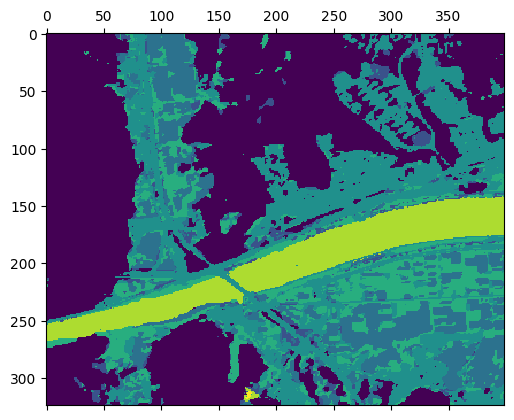

In [50]:
CITY_BOUNDING_BOX = create_bounding_box(CITY, 3000)

ls_read_export = ls_median.reproject(ls_read.first().select("B1").projection())
channel = geemap.ee_to_numpy(wc_read, region=CITY_BOUNDING_BOX, bands = ['Map'], default_value=0.0)
plt.matshow(channel)

In [255]:
def create_timelaps_data(point, years, months=None, verbose=True):
    if months is None:
        months = [(1, 12)]
    bounding_box = create_bounding_box(point, 14000) # We cant export more ATM
    resulting_images = []
    for year in years:
        for month_range in months:
            if verbose:
                print(f"At Year: {year}, Months: {month_range}")
            ls_read = (COMBINED_LANDSAT
                    .filterBounds(point)
                    .filterDate(f'{year}-01-01', f'{year+1}-01-01')
                    .filter(ee.Filter.calendarRange(month_range[0], month_range[1], field="month"))
                    .map(mask_clouds)
                   )
            ls_median = ls_read.median()
            ls_read_export = ls_median.reproject(ls_read.first().select("B1").projection())

            image = geemap.ee_to_numpy(ls_read_export, region=bounding_box, bands = ['B3', "B2", "B1"], default_value=0.0)
            resulting_images.append((image, f"Year: {year}, Months: {month_range}"))
    return resulting_images

YEARS = list(range(1990, 1992))
MONTHS = [(1, 12)]
TIMELAPS_IMAGES =  create_timelaps_data(CITY, YEARS, months=MONTHS)
print("Done!")

At Year: 1990, Months: (2, 11)
At Year: 1991, Months: (2, 11)
Done!


0
0
1
Done!
0


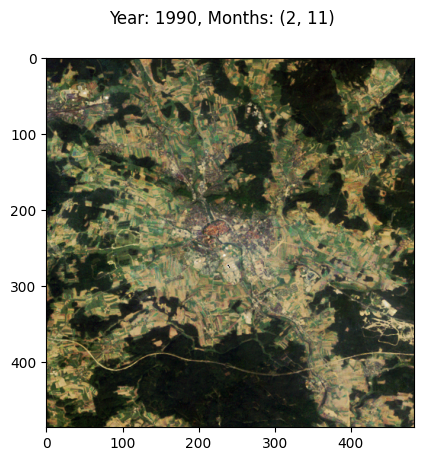

In [256]:
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

YEAR_START = 1988
YEAR_END = 2023

CITY_NAME = "Hanoi"

bands_over_years_ = TIMELAPS_IMAGES#[1:]
animation_range = len(bands_over_years_)

fig = plt.figure()
ax = plt.axes()


year_frame = norm(bands_over_years_[-1][0])
IMG_2022 = exposure.equalize_adapthist(year_frame, clip_limit=0.02)


def animate(year_idx):
    print(year_idx)
    img, title = bands_over_years_[year_idx]
    img = norm(img)
    img = exposure.match_histograms(img, IMG_2022, channel_axis=-1)
    ax.imshow(img)
    fig.suptitle(title)
    
    
ani = FuncAnimation(fig, animate, interval = 500, frames = animation_range, repeat = False)


ani.save(f'city_plots/{CITY_NAME}_plot.mp4')
print("Done!")